In [2]:
using DrWatson
@quickactivate "SpinOneChain"

In [63]:
using JLD2
using Glob
using PyPlot
using PyCall
using DataFrames
using SQLite
using DBInterface

cm = pyimport("matplotlib.cm")

inset_locator = pyimport("mpl_toolkits.axes_grid1.inset_locator")
gridspec = pyimport("matplotlib.gridspec")

PyObject <module 'matplotlib.gridspec' from 'C:\\Users\\kyungminlee\\miniconda3\\envs\\conda_jl\\lib\\site-packages\\matplotlib\\gridspec.py'>

In [4]:
df = DataFrame()
for fpath in Glob.glob("magnon*.jld2", datadir())
    @load fpath N D energy state
    push!(df, (N=N, D=D, energy=energy, state=state))
end

In [5]:
df

655×4 DataFrame
 Row │ N      D        energy    state 
     │ Int64  Float64  Float64   Int64 
─────┼─────────────────────────────────
   1 │   112     0.05  -117.6        1
   2 │   112     0.05  -117.55       2
   3 │   112     0.05  -117.501      3
   4 │   112     0.06  -118.72       1
   5 │   112     0.06  -118.66       2
   6 │   112     0.06  -118.601      3
   7 │   112     0.07  -119.84       1
   8 │   112     0.07  -119.77       2
   9 │   112     0.07  -119.701      3
  10 │   112     0.08  -120.96       1
  11 │   112     0.08  -120.88       2
  ⋮  │   ⋮       ⋮        ⋮        ⋮
 646 │    96     0.3   -124.214      3
 647 │    96     0.45  -139.2        1
 648 │    96     0.45  -138.75       2
 649 │    96     0.45  -138.334      3
 650 │    96     0.4   -134.4        1
 651 │    96     0.4   -134.0        2
 652 │    96     0.4   -133.626      3
 653 │    96     0.5   -144.0        1
 654 │    96     0.5   -143.5        2
 655 │    96     0.5   -143.043      3
                       634 rows omitted

In [6]:
combined_df = DataFrame()
for subdf in groupby(df, [:N, :D])
    N = subdf[1, :N]
    D = subdf[1, :D]
    any(subdf[:, :state] .== 1) || continue
    any(subdf[:, :state] .== 2) || continue
    any(subdf[:, :state] .== 3) || continue
    
    E0 = first(subdf[subdf[:, :state] .== 1, :energy])
    E1 = first(subdf[subdf[:, :state] .== 2, :energy])
    E2 = first(subdf[subdf[:, :state] .== 3, :energy])
    push!(combined_df, (N=N, D=D, E0=E0, E1=E1, E2=E2))
end

In [7]:
# subdf = df[df[:, :N] .== 32, :]
subdf = combined_df
PyPlot.plot(subdf[:, :D], subdf[:, :E1] - subdf[:, :E0], ".", alpha=0.5)
PyPlot.plot(subdf[:, :D], subdf[:, :E2] - subdf[:, :E0], ".", alpha=0.5)
PyPlot.xlim(0, 1)
PyPlot.ylim(0, 2)

(0.0, 2.0)

In [8]:
subdf

217×5 DataFrame
 Row │ N      D        E0       E1       E2       
     │ Int64  Float64  Float64  Float64  Float64  
─────┼────────────────────────────────────────────
   1 │   112     0.05  -117.6   -117.55  -117.501
   2 │   112     0.06  -118.72  -118.66  -118.601
   3 │   112     0.07  -119.84  -119.77  -119.701
   4 │   112     0.08  -120.96  -120.88  -120.801
   5 │   112     0.09  -122.08  -121.99  -121.901
   6 │   112     0.15  -128.8   -128.65  -128.503
   7 │   112     0.1   -123.2   -123.1   -123.002
   8 │   112     0.25  -140.0   -139.75  -139.509
   9 │   112     0.2   -134.4   -134.2   -134.006
  10 │   112     0.35  -151.2   -150.85  -150.519
  11 │   112     0.3   -145.6   -145.3   -145.014
  ⋮  │   ⋮       ⋮        ⋮        ⋮        ⋮
 208 │    96     0.09  -104.64  -104.55  -104.461
 209 │    96     0.15  -110.4   -110.25  -110.103
 210 │    96     0.1   -105.6   -105.5   -105.402
 211 │    96     0.25  -120.0   -119.75  -119.509
 212 │    96     0.2   -115.2   -115.0   -114.806
 213 │    96     0.35  -129.6   -129.25  -128.919
 214 │    96     0.3   -124.8   -124.5   -124.214
 215 │    96     0.45  -139.2   -138.75  -138.334
 216 │    96     0.4   -134.4   -134.0   -133.626
 217 │    96     0.5   -144.0   -143.5   -143.043
                                  196 rows omitted

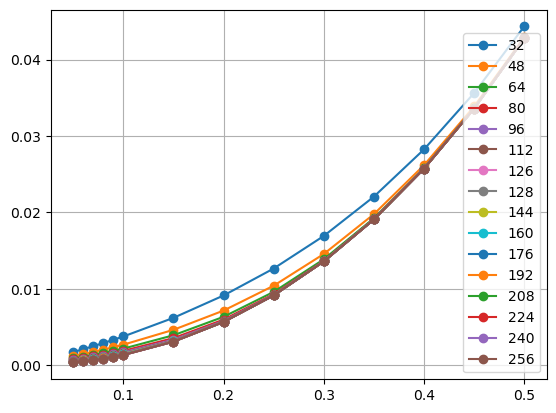

In [9]:



for subdf in groupby(combined_df, :N; sort=true)    
    xs = subdf[:, :D]
    ys = -(subdf[:, :E2] - 2 .* subdf[:, :E1] + subdf[:, :E0])
    zs = subdf[:, :N]
    idx = sortperm(xs)
    xs = xs[idx]
    ys = ys[idx]
    zs = zs[idx]    
    
    ymax = maximum(ys)
    ymin = minimum(ys)
#     yshift = (ys .- ymin) ./ (ymax - ymin)
    PyPlot.plot(xs, ys, "o-", label="$(subdf[1, :N])")
end
#PyPlot.ylim(0, nothing)
#PyPlot.xlim(0, nothing)
PyPlot.legend()
PyPlot.grid()

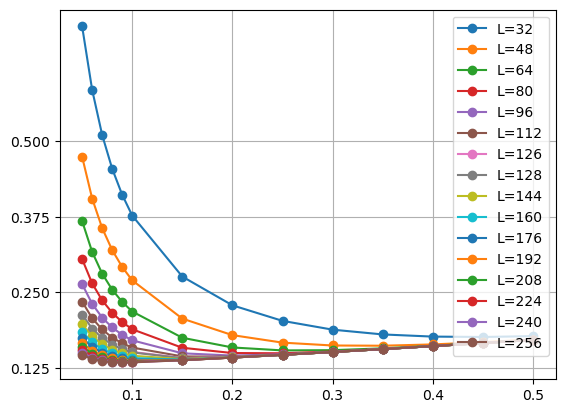

In [10]:



for subdf in groupby(combined_df, :N; sort=true)    
    xs = subdf[:, :D]
    ys = -(subdf[:, :E2] - 2 .* subdf[:, :E1] + subdf[:, :E0])
    zs = subdf[:, :N]
    idx = sortperm(xs)
    xs = xs[idx]
    ys = ys[idx]
    zs = zs[idx]    
    
    ymax = maximum(ys)
    ymin = minimum(ys)
#     yshift = (ys .- ymin) ./ (ymax - ymin)
    PyPlot.plot(xs, ys ./ xs.^2, "o-", label="L=$(subdf[1, :N])")
end
PyPlot.yticks([1/8, 2/8, 3/8, 4/8, ])
#PyPlot.ylim(0, nothing)
#PyPlot.xlim(0, nothing)
PyPlot.legend()
PyPlot.grid()

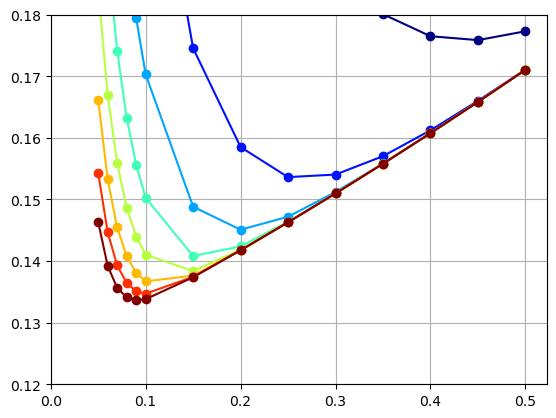

In [13]:
cmap = cm.jet

filtered_df = combined_df[ combined_df[:, :N] .% 32 .== 0, :]
unique_N = unique(filtered_df[:, :N])
for (isub, subdf) in enumerate(groupby(filtered_df, :N; sort=true))
    xs = subdf[:, :D]
    ys = -(subdf[:, :E2] - 2 .* subdf[:, :E1] + subdf[:, :E0])
    zs = subdf[:, :N]
    idx = sortperm(xs)
    xs = xs[idx]
    ys = ys[idx]
    zs = zs[idx]    
    
    ymax = maximum(ys)
    ymin = minimum(ys)
#     yshift = (ys .- ymin) ./ (ymax - ymin)
    PyPlot.plot(xs, ys ./ xs.^2, "o-", label="L=$(subdf[1, :N])", color=cmap( (isub-1) / (length(unique_N) - 1)) )
end
# PyPlot.yticks([1/8, 2/8, 3/8, 4/8, ])
PyPlot.ylim(0.12, 0.18)
PyPlot.xlim(0, nothing)
# PyPlot.legend()

PyPlot.grid()

In [14]:
using LsqFit

LoadError: [91mArgumentError: Package LsqFit not found in current path:[39m
[91m- Run `import Pkg; Pkg.add("LsqFit")` to install the LsqFit package.[39m


model (generic function with 1 method)

In [21]:
using LsqFit

┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1278


In [58]:
@. model(x, p) = p[1] + p[2] / x^(p[3])

model (generic function with 1 method)

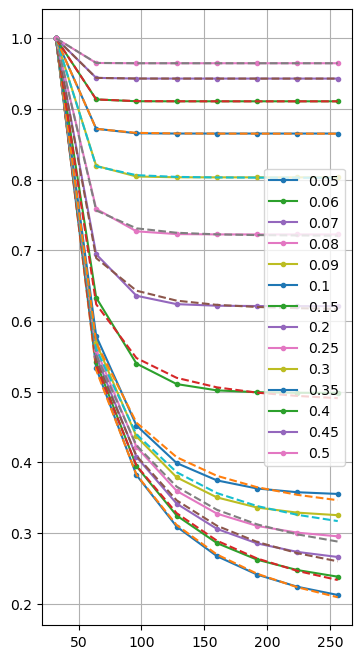

0.05	0.11966253268119798
0.06	0.1553558052427504
0.07	0.1933335465534412
0.08	0.2323624836048856
0.09	0.2713891710173494
0.1	0.3096580523720497
0.15	0.47974216236071404
0.2	0.6141583591142897
0.25	0.7200217390831161
0.3	0.8024283202681074
0.35	0.8649426379033832
0.4	0.9107249155094536
0.45	0.9429280560863182
0.5	0.9646400522038421


PyObject <matplotlib.legend.Legend object at 0x00000000018FE9A0>

In [59]:

fig = PyPlot.figure(figsize=(4, 8))
# fig = PyPlot.figure(figsize=(12, 12))
ax = fig.gca()
# axins = inset_locator.inset_axes(ax, width="35%", height="45%", bbox_to_anchor=(-0.4, -0.05, 1, 1), bbox_transform=ax.transAxes)


filtered_df = combined_df[ combined_df[:, :N] .% 32 .== 0, :]
# filtered_df = filtered_df[ filtered_df[:, :D] .>= 0.05, :]
unique_N = unique(filtered_df[:, :N])
for (isub, subdf) in enumerate(groupby(filtered_df, :D; sort=true))
    
# for (isub, subdf) in enumerate(groupby(combined_df, :N; sort=true))
#     if subdf[1, :N] <= 32
#         continue
#     end
    xs = subdf[:, :N]
    ys = -(subdf[:, :E2] - 2 .* subdf[:, :E1] + subdf[:, :E0])
    idx = sortperm(xs)
    xs = xs[idx]
    ys = ys[idx]
    ys ./= ys[1]
#     ys ./= ys[end]
    ax.plot(xs, ys, ".-", label="$(subdf[1, :D])") #color=cmap( (isub-1) / (length(unique_N) - 1)), alpha=1)

    popt = curve_fit(model, xs, ys, [0.1, 0.1, 0.1]).param
    xs_fit = xs
    ys_fit = [model(x, popt) for x in xs_fit]
    ax.plot(xs_fit, ys_fit, "--") #, label="A=$(popt[1])")
    println(first(subdf[:, :D]), "\t", popt[1])
end
ax.grid()
ax.legend()


PyObject <module 'matplotlib.gridspec' from 'C:\\Users\\kyungminlee\\miniconda3\\envs\\conda_jl\\lib\\site-packages\\matplotlib\\gridspec.py'>

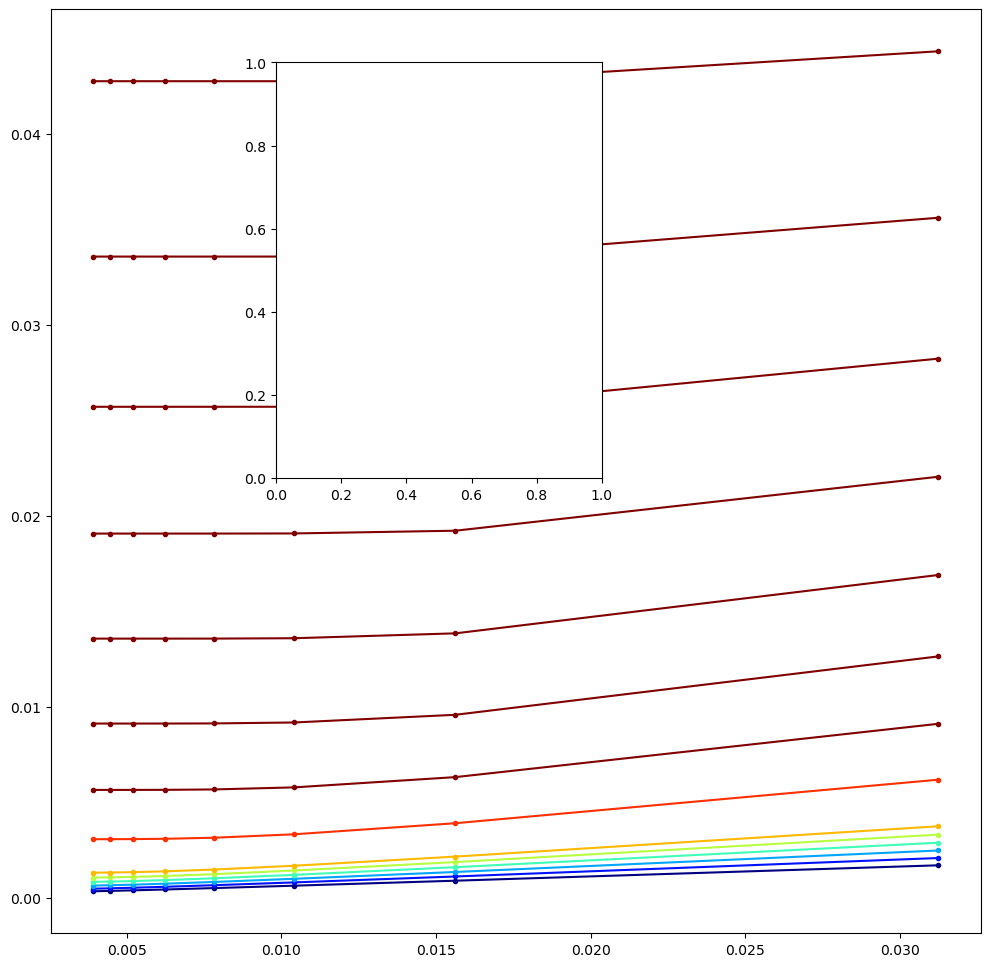

In [60]:
using LsqFit

model (generic function with 1 method)

In [73]:

fig = PyPlot.figure(figsize=(4, 3.5))
# fig = PyPlot.figure(figsize=(12, 12))
ax = fig.gca()
axins = inset_locator.inset_axes(ax, width="35%", height="45%", bbox_to_anchor=(-0.4, -0.05, 1, 1), bbox_transform=ax.transAxes)


filtered_df = combined_df[ combined_df[:, :N] .% 32 .== 0, :]
filtered_df = filtered_df[ filtered_df[:, :D] .>= 0.05, :]
unique_N = unique(filtered_df[:, :N])
for (isub, subdf) in enumerate(groupby(filtered_df, :N; sort=true))
    
# for (isub, subdf) in enumerate(groupby(combined_df, :N; sort=true))
#     if subdf[1, :N] <= 32
#         continue
#     end
    xs = subdf[:, :D]
    ys = -(subdf[:, :E2] - 2 .* subdf[:, :E1] + subdf[:, :E0])
    zs = subdf[:, :N]
    idx = sortperm(xs)
    xs = xs[idx]
    ys = ys[idx]
    zs = zs[idx]    
    
#     xs = [0, xs...]
#     ys = [0, ys...]
#     yshift = (ys .- ymin) ./ (ymax - ymin)
    ax.plot(xs, ys, ".-", label="$(subdf[1, :N])", color=cmap( (isub-1) / (length(unique_N) - 1)), alpha=1)
    axins.plot(xs, ys ./ xs.^2, ".-", color=cmap( (isub-1) / (length(unique_N) - 1)), alpha=1)
    
    
    if first(subdf[:, :N]) == 256
        let
            @. model(x, p) = p[1] * x + p[2]
            
            xs_sel = xs[xs .>= 0.15] 
            ys_sel = ys[xs .>= 0.15]
            ys_sel ./= xs_sel.^2
            
            @show xs_sel, ys_sel
            f = curve_fit(model, xs_sel, ys_sel, [0.1, 0.1])
            xs_fit = 0:0.1:0.5
            ys_fit = model(xs_fit, f.param)
            axins.plot(xs_fit, ys_fit, "k--", linewidth=0.5)
            @show f.param
        end
    end
end

let
end
axins.tick_params(labelsize=8)
#PyPlot.setp(axins.get_xticklabels(), visible=false)
ax.set_xlabel(raw"$D$", fontsize=16)
ax.set_ylabel(raw"$E_B$", fontsize=16)
axins.set_ylabel(raw"$E_B/D^2$", fontsize=10)
axins.set_xlabel(raw"$D$", fontsize=10)
axins.set_yticks([0.1, 0.12, 0.14, 0.16, 0.18, 0.2])
axins.set_ylim(0.12, 0.19)
axins.set_xlim(0, nothing)
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.045)
ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04])
#PyPlot.ylim(0, nothing)
#PyPlot.xlim(0, nothing)
ax.legend(loc=4, fontsize=7, title="\$L=\$")
#PyPlot.grid()
fig.savefig("two-magnon-binding-energy.pdf", dpi=300, bbox_inches="tight")

(xs_sel, ys_sel) = ([0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], [0.1373763315213081, 0.14175485376313188, 0.146297665783095, 0.15098128366730634, 0.15580214440489024, 0.16075594825473158, 0.16583691598116498, 0.17103765443471275])


f.param = [0.09624649516799934, 0.12245023879637011]


In [270]:
pwd()

"C:\\Users\\kyungminlee\\Dropbox\\Code\\SpinOneChain\\notebooks"

In [219]:

fig = PyPlot.figure(figsize=(4, 4))
gs = fig.add_gridspec(3,1)

axins = fig.add_subplot(gs.__getitem__((0,0)))
ax = fig.add_subplot(gs.__getitem__((py"slice(1,3)", 0)))

# ax = fig.add_subplot(2,1,2)
# axins = fig.add_subplot(2,1,1, sharex=ax)
#axins = inset_locator.inset_axes(ax, width="40%", height="40%", loc=2, borderpad=2)

for (isub, subdf) in enumerate(groupby(combined_df, :N; sort=true))
#     if subdf[1, :N] < 64
#         continue
#     end
    xs = subdf[:, :D]
    ys = -(subdf[:, :E2] - 2 .* subdf[:, :E1] + subdf[:, :E0])
    zs = subdf[:, :N]
    idx = sortperm(xs)
    xs = xs[idx]
    ys = ys[idx]
    zs = zs[idx]    
    
#     xs = [0, xs...]
#     ys = [0, ys...]
#     yshift = (ys .- ymin) ./ (ymax - ymin)
    ax.plot(xs, ys, ".-", label="$(subdf[1, :N])")
    axins.plot(xs, ys ./ xs.^2, ".-")
end

# axins.tick_params(labelsize=8)
PyPlot.setp(axins.get_xticklabels(), visible=false)
ax.set_xlabel("D", fontsize=16)
ax.set_ylabel(raw"$E_B$", fontsize=16)
axins.set_ylabel(raw"$E_B/D^2$", fontsize=16)
axins.set_yticks([0.125, 0.15, 0.175, 0.2])
axins.set_ylim(0.12, 0.2)
#PyPlot.ylim(0, nothing)
#PyPlot.xlim(0, nothing)
#PyPlot.legend()
#PyPlot.grid()

PyPlot.subplots_adjust(wspace=0, hspace=0)

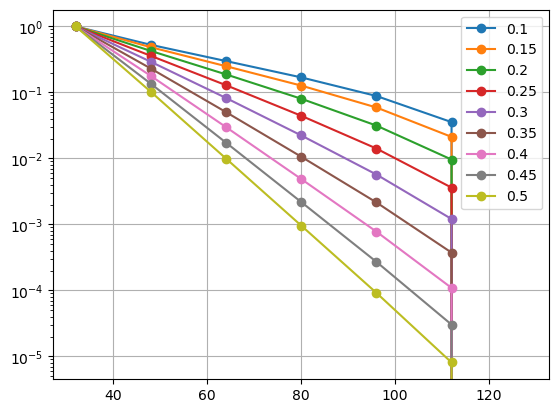

In [134]:
subdf = combined_df
# subdf = df[df[:, :N] .== 32, :]

for subdf in groupby(combined_df, :D; sort=true)    
    xs = subdf[:, :D]
    ys = -(subdf[:, :E2] - 2 .* subdf[:, :E1] + subdf[:, :E0])
    zs = subdf[:, :N]
    idx = sortperm(zs)
    xs = xs[idx]
    ys = ys[idx]
    zs = zs[idx]    
    
    ymax = maximum(ys)
    ymin = minimum(ys)
    yshift = (ys .- ymin) ./ (ymax - ymin)
    PyPlot.plot(zs, yshift, "o-", label="$(subdf[1, :D])")
end
#PyPlot.ylim(0, nothing)
#PyPlot.xlim(0, nothing)
PyPlot.yscale("log")
PyPlot.legend()
PyPlot.grid()

In [19]:
# #subdf = df[df[:, :N] .== 32, :]
# PyPlot.plot(subdf[:, :D], subdf[:, :E2] - subdf[:, :E1], "o", alpha=1)
# PyPlot.xscale("log")
# PyPlot.yscale("log")
# #PyPlot.xlim(0, 1)
# #PyPlot.ylim(0, 2)

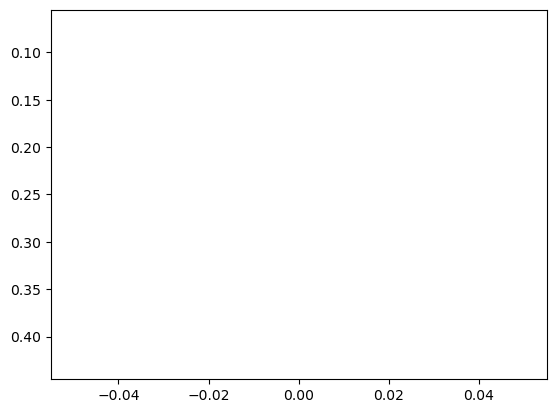

subdf[:, :E1] - subdf[:, :E0] = Float64[]


(0.445, 0.05500000000000001)

In [20]:
let
    subdf = combined_df[combined_df[:, :D] .== 0.05, :]
    @show subdf[:, :E1] - subdf[:, :E0]
    PyPlot.plot(subdf[:, :N], subdf[:, :E1] - subdf[:, :E0], "o", alpha=1)
    PyPlot.ylim(0.4450, nothing)
end

In [8]:
colors = ["red", "orange", "yellow", "green", "blue", "navy", "purple"]
N = 128

fig = PyPlot.figure(figsize=(8, 3))
for (iD, D) in enumerate([1.0, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05])
    @load datadir("domainwall_N=$(N)_D=$(D)_state=2.jld2") Sz Sz2
    midpoint = (N+1)/2
    lc = ceil(Int, midpoint)
    xs = 0.5:(N-lc+0.5)
    ys = 1.0 .- abs.(Sz[lc:N])
#     xs = 0.5:(15+0.5)
#     ys = 1.0 .- abs.(Sz[lc:lc+15])    
    PyPlot.plot(xs, ys, "o-", color=colors[iD], label="D=$D", alpha=0.5, markersize=3)
end

for (iD, D) in enumerate([1.0, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05])
    @load datadir("domainwall_N=$(N)_D=$(D)_state=3.jld2") Sz Sz2
    midpoint = N/2
    lc = ceil(Int, midpoint)
    xs = 0:(N-lc)
    ys = 1.0 .- abs.(Sz[lc:N])    
#     xs = 0:15
#     ys = 1.0 .- abs.(Sz[lc:lc+15])
    PyPlot.plot(xs, ys, "^-", color=colors[iD], alpha=0.5, markersize=3) #, label="D=$D")
end
PyPlot.xlim(0, nothing)
PyPlot.yscale("log")
PyPlot.ylim(1E-13, nothing)
PyPlot.xlim(-0.5, N/2-0.5)
PyPlot.legend(loc=1, fontsize=6)

PyObject <matplotlib.legend.Legend object at 0x0000000001928D30>

In [9]:
for D in [1.0, 0.5, 0.2, 0.1, 0.05, 0.02]
    N = 64
    @load datadir("domainwall_N=$(N)_D=$(D)_state=3.jld2") Sz Sz2
    midpoint = N/2
    lc = ceil(Int, midpoint)
    xs = 0:(N-lc)
    ys = 1.0 .- abs.(Sz[lc:N])
    PyPlot.plot(xs, ys, "^-", label="D=$D")
end
PyPlot.xlim(0, nothing)
PyPlot.yscale("log")
PyPlot.legend()

PyObject <matplotlib.legend.Legend object at 0x0000000001A84FD0>

In [10]:
PyPlot.plot(1 .- abs.(Sz1), "x-", label=raw"$\uparrow\downarrow$")
PyPlot.plot(1 .- abs.(Sz2), "^-", label=raw"$\uparrow0\downarrow$")
# PyPlot.xlim(10, 20)
PyPlot.legend()
# PyPlot.xlim(15, 45)

LoadError: UndefVarError: Sz1 not defined